In [1]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.cpu)

def Scan():
    data = tf.input([-1], tf.int32)
    N = data.shape[0]
    group_size = 128
    groups = (N + group_size - 1) / group_size

    gid, eid = tf.indices([groups, group_size])
    grouped = tf.select(gid * group_size + eid < N, data[gid * group_size + eid], 0)
    sums = tf.sum(grouped, 1)

    #group_scans = tf.scan(sums)
    #full_scan = tf.scan(grouped, 1) + group_scans[gid]

    group_scans = tf.buffer([groups], tf.int32)
    gid, = sums.indices
    scan = tf.zeros([1], tf.int32)
    with tf.loop(groups) as i:
        group_scans[i] = scan
        scan.val += sums[i]
    full_scan = tf.buffer([N], tf.int32)

    local_scan = group_scans[gid]*1
    with tf.loop(group_size) as i:
        index = gid * group_size + i
        tf.if_cond(index >= N, lambda: tf.break_loop())
        local_scan.val += data[index]
        full_scan[index] = local_scan

    return [full_scan]

scan_program = tf.compile(Scan)

TensorFrost module loaded!
Scan:
  Kernel count: 3
  Intermediate buffers: 2
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 537
  IR Compile time: 3.660900 ms
  Compiler time: 5851.240723 ms



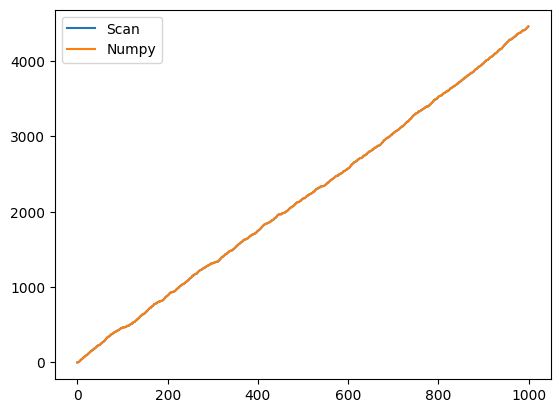

Error:  0


In [2]:
# Generate some random data to scan (ints between 0 and 10)
data = np.random.randint(0, 10, 1000, dtype=np.int32)

data_tf = tf.tensor(data)
scan_tf, = scan_program(data_tf)

# do scan in numpy
scan_np = np.cumsum(data)

# Plot the original data and the scan
scan = scan_tf.numpy
plt.plot(scan, label="Scan")
plt.plot(scan_np, label="Numpy")
plt.legend()
plt.show()

#print error
print("Error: ", np.max(np.abs(scan - scan_np)))